<a href="https://colab.research.google.com/github/anthopper/Affective-Code/blob/main/MarmergedAnalysis2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature selecting & Modeling

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest
from statsmodels.tsa.stattools import adfuller
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

### Load in the data files
from google.colab import drive

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [27]:
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/' 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
cd /Users/Kit/Dropbox/Disseration/Data/Interviews/Mar/Merged\ Mar\ Data

[Errno 2] No such file or directory: '/Users/Kit/Dropbox/Disseration/Data/Interviews/Mar/Merged Mar Data'
/content


In [28]:
df1 = pd.read_csv('/content/gdrive/My Drive/MarMerged1.csv',header=0)
df2 = pd.read_csv('/content/gdrive/My Drive/MarMerged2.csv',header=0)
## add the ending time of the first data table (df1) to the starting time of the second (df2)
df2['millisec'] = df2['millisec'] + 984300.0

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (719,722,723,726,727) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [29]:
df = pd.concat([df1, df2])
df = df.reset_index(drop=True)

In [34]:
df.shape

(83719, 732)

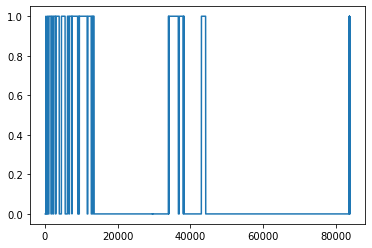

In [30]:
df['Elaborated'].plot()


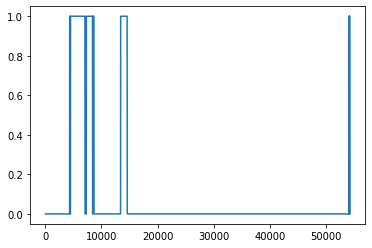

In [13]:
df2['Elaborated'].plot()

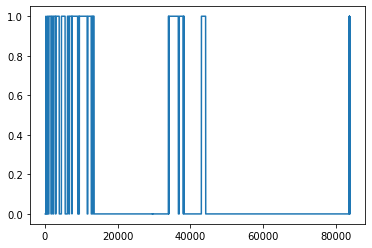

In [14]:
df['Elaborated'].plot()

In [38]:
au= pd.concat([df[' timestamp'], df.iloc[:,-51:-34],df['Elaborated'], df['Hypothesized']], axis = 1)

,timestamp,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,Elaborated,Hypothesized
timestamp,1.000000,0.019630,0.041661,0.280929,-0.054123,-0.086855,-0.025011,-0.102479,0.177549,-0.078748,-0.049298,-0.012598,0.068711,0.091244,0.071956,-0.057227,0.085007,-0.083683,-0.480929,-0.446029
AU01_r,0.019630,1.000000,0.525442,0.314529,0.077850,-0.171237,-0.112473,-0.111501,0.192759,-0.114461,-0.020396,0.132385,0.100178,-0.110377,-0.004462,0.071973,0.147788,0.134694,0.050945,0.009446
AU02_r,0.041661,0.525442,1.000000,0.163223,0.185081,-0.081770,-0.015760,-0.116806,-0.002090,-0.042692,0.025453,-0.033399,0.021404,-0.058516,0.063854,0.019885,0.133576,0.088608,0.010813,-0.044049
AU04_r,0.280929,0.314529,0.163223,1.000000,-0.091542,-0.246663,-0.146979,0.045396,0.481120,-0.207504,-0.081624,0.094752,0.160898,-0.112631,-0.135008,0.078518,0.201733,-0.015152,-0.109935,-0.039900
AU05_r,-0.054123,0.077850,0.185081,-0.091542,1.000000,-0.068783,-0.001393,-0.073108,-0.113584,-0.026045,-0.008254,-0.098584,-0.085073,-0.033158,0.098894,0.051208,0.091082,-0.152602,0.026873,-0.024155
AU06_r,-0.086855,-0.171237,-0.081770,-0.246663,-0.068783,1.000000,0.649182,0.131933,0.184257,0.915236,0.544205,-0.180713,-0.220657,0.141873,-0.010414,0.315800,0.013628,0.102797,0.214557,0.017572
AU07_r,-0.025011,-0.112473,-0.015760,-0.146979,-0.001393,0.649182,1.000000,0.181956,0.081947,0.558679,0.352380,-0.273810,-0.267913,0.096134,-0.026159,0.285683,0.062235,0.232696,0.225368,0.101132
AU09_r,-0.102479,-0.111501,-0.116806,0.045396,-0.073108,0.131933,0.181956,1.000000,0.251897,0.163793,-0.050409,0.018401,-0.183442,0.019904,-0.092806,0.233746,-0.116181,0.185778,0.128420,0.052716
AU10_r,0.177549,0.192759,-0.002090,0.481120,-0.113584,0.184257,0.081947,0.251897,1.000000,0.253954,0.179508,0.074770,0.059596,0.014059,-0.102372,0.352238,0.146215,-0.045955,-0.064002,-0.088900
AU12_r,-0.078748,-0.114461,-0.042692,-0.207504,-0.026045,0.915236,0.558679,0.163793,0.253954,1.000000,0.547001,-0.172141,-0.235112,0.120540,0.019890,0.319798,-0.033884,0.057665,0.174806,0.034912


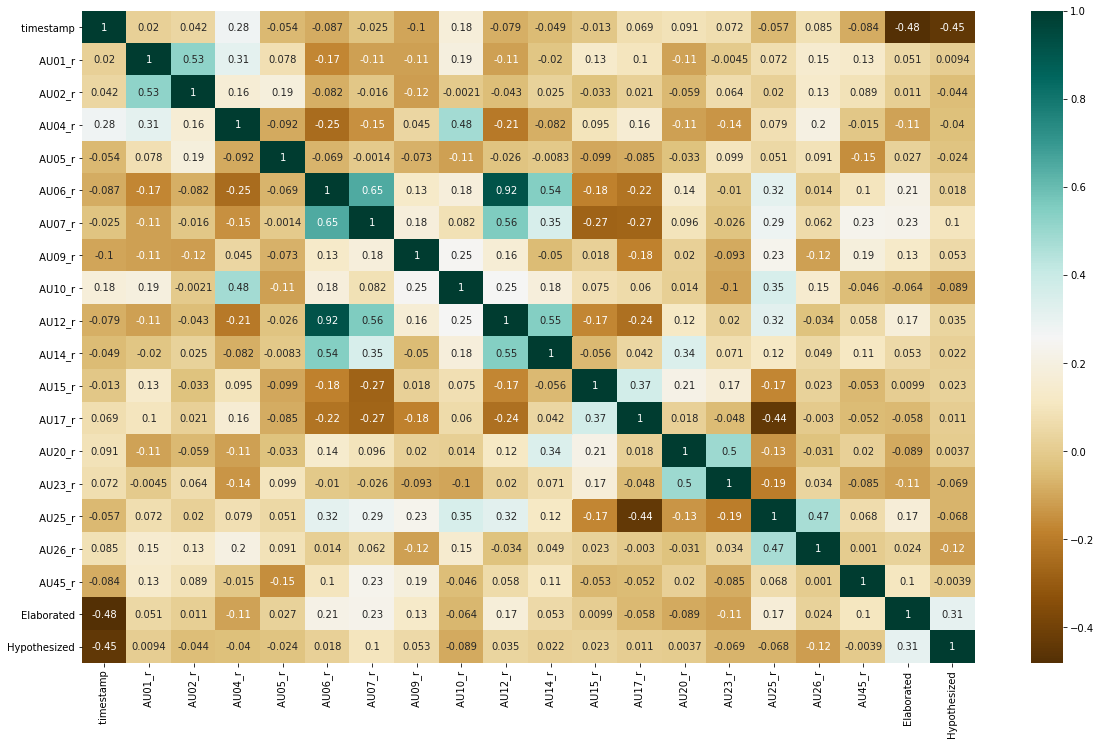

In [18]:
plt.figure(figsize=(20,12))
c= au.corr()
sns.heatmap(c,cmap="BrBG",annot=True)
c

In [19]:
au = au.dropna()

In [ ]:
#pd.set_option("display.max_rows", None, "display.max_columns", None)

In [ ]:
sum(au[' timestamp'] == NaN) 

NameError: name 'NaN' is not defined

## Feature selecting 
### PCA
In this part, actually I only use PCA to generate another feature for the data. I try to get a comprehensive view of the data and check its change law with time. At the same time, it can also be a contrast and criteria for other single features.

In [20]:
colpca = PCA(n_components=1).fit_transform(au.iloc[:, 1:18])
au = pd.concat([au, pd.DataFrame(colpca,index=None,columns = ['PCA'])], axis = 1)

### Clustering & Selecting features 
Here I use K-means as a cluster to cluster the data into 6 categories, for there are 6 common human facial expressions including happiness, surprise, sadness, anger, disgust and fear [2]. After cluster them and give them a label, I can find the most important features with classification while adding or dropping single features. In addition, it can also give a criteria to classification model in next section.


In [ ]:
y_pre = KMeans(n_clusters = 6).fit_predict(au.iloc[:, 1:18])
au = pd.concat([au, pd.DataFrame(y_pre,index=None,columns = ['label'])], axis = 1)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

For feature selection, I used the function SelectKBest from sklearn, with the score function chi2. SelectKBest is one of single variable feature selection method. The principle of them is to calculate a statistical index of each variable separately, and determine which indexes are important according to the index. After finding the important features, it exclude those that are not important. In this experiment, I take the score from chi2 as the single variable.

In [ ]:
selector= SelectKBest(score_func= chi2, k= 5)
selector.fit(au.iloc[:, 1:18], au['label'])
Scores= selector.scores_

In [ ]:
selector.get_support(True)

array([ 4,  8, 12, 14, 16])

In [23]:
feature = [' AU06_r', ' AU12_r', ' AU20_r', ' AU25_r', ' AU45_r', 'PCA']

As a result, I found the 5 most important features is AU25, AU12, AU06, AU45 and AU20. In the modeling part, I use dataset that only includes these important features along with the PCA feature.

## Model
### Time Series Model

In this model, I check every feature seperately. First I plot it calculating mean for every 400 continuous frames, for the whole 80000-size data is too glitchy. Then I also plot the rolling statistics, including mean and std, with a window of 10 for every figure.

(-0.54, 11.339999999999998)

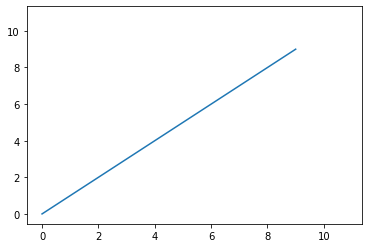

In [62]:
plt.plot(range(0, 10))
#Initial axes limits are 0, 10

scale_factor = 1.2

xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

plt.xlim(xmin * scale_factor, xmax * scale_factor)
plt.ylim(ymin * scale_factor, ymax * scale_factor)

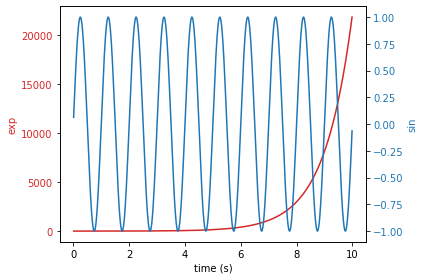

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Create some mock data
t = np.arange(0.01, 10.0, 0.01)
data1 = np.exp(t)
data2 = np.sin(2 * np.pi * t)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('exp', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [57]:
def check_adfuller(ds,name):
    result = adfuller(ds, autolag='AIC')
    print(name+': ')
    print('Test statistic: ' , result[0])
    print('p-value: '  ,result[1])
    print('Critical Values:' ,result[4])

def check_mean_std(ds,pos,name):
    #Rolling statistics
    rolmean = pd.Series(ds).rolling(window=10).mean()
    rolstd = pd.Series(ds).rolling(window=10).std()
    elabores = pd.Series(df['Elaborated'])
    plt.subplot(pos)
    orig = plt.plot(ds,label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    elaborated = plt.plot(elabores ,color='purple', label = 'Elaborations')
    plt.xlabel("Time")
    plt.ylabel("Mean Score")
    plt.title('Rolling Mean & Standard Deviation for '+ name)
    plt.legend()


def pic(target,ran,pos):
    Mean = []
    for i in range(0,au.shape[0], ran):
        tem = np.mean(au[target][i:i+ran])
        Mean.append(tem)
    check_mean_std(Mean,pos,target)
    check_adfuller(Mean,target)


 AU06_r: 
Test statistic:  nan
p-value:  nan
Critical Values: {'1%': -3.4620315036789666, '5%': -2.8754705024827127, '10%': -2.5741950726860647}
 AU12_r: 
Test statistic:  nan
p-value:  nan
Critical Values: {'1%': -3.4620315036789666, '5%': -2.8754705024827127, '10%': -2.5741950726860647}
 AU20_r: 
Test statistic:  nan
p-value:  nan
Critical Values: {'1%': -3.4620315036789666, '5%': -2.8754705024827127, '10%': -2.5741950726860647}
 AU25_r: 
Test statistic:  nan
p-value:  nan
Critical Values: {'1%': -3.4620315036789666, '5%': -2.8754705024827127, '10%': -2.5741950726860647}
 AU45_r: 
Test statistic:  nan
p-value:  nan
Critical Values: {'1%': -3.4620315036789666, '5%': -2.8754705024827127, '10%': -2.5741950726860647}


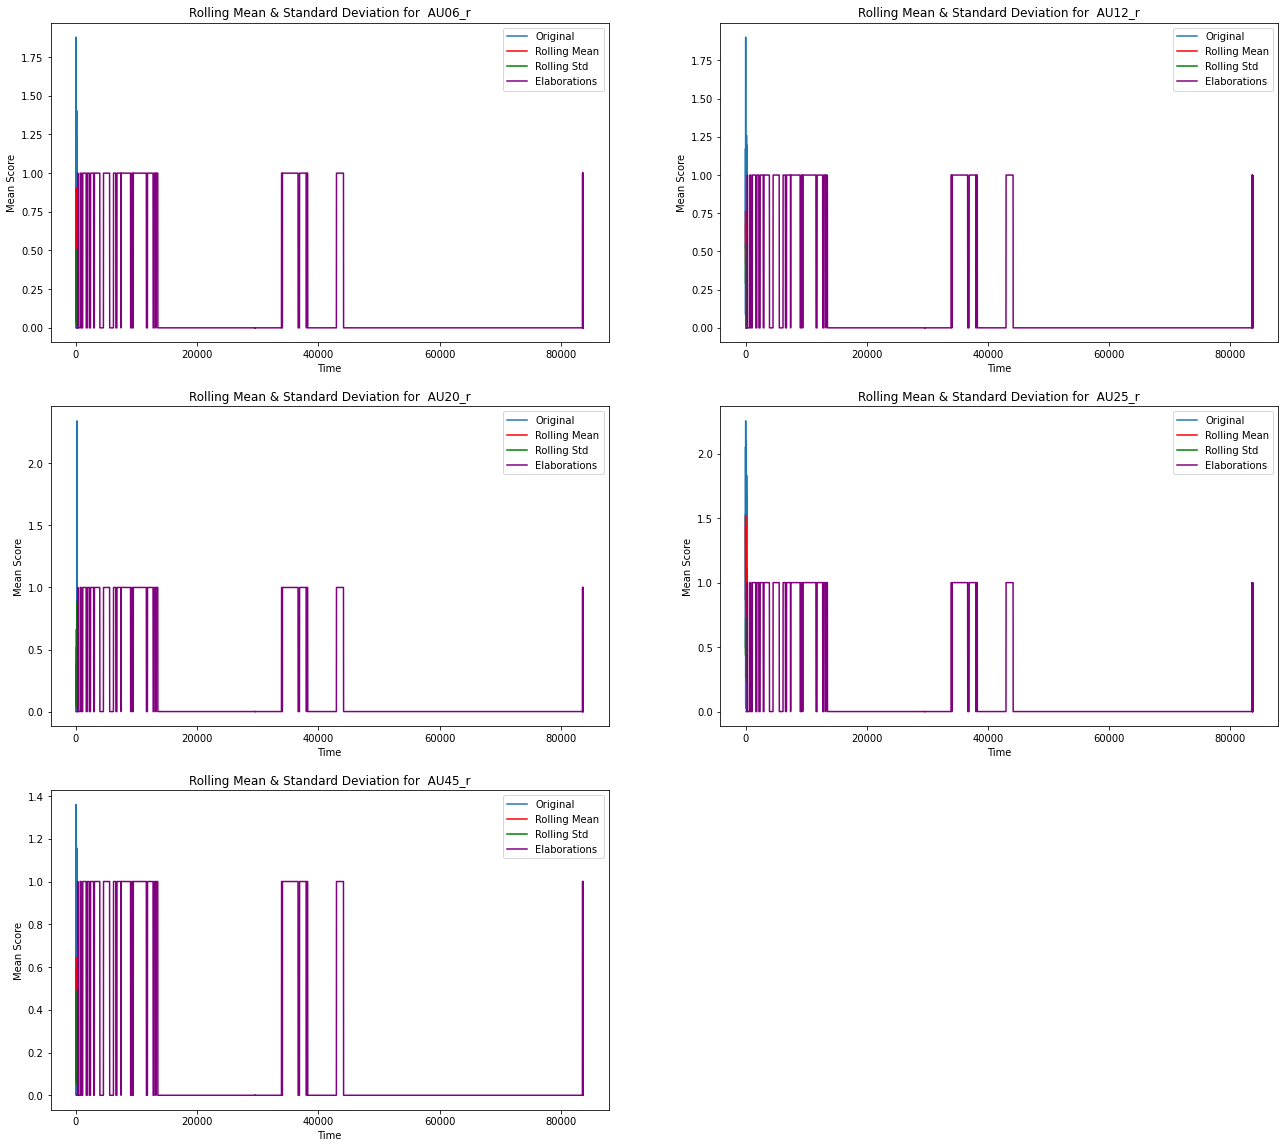

In [58]:
plt.figure(figsize=(22,20)) 
ran, pos = 400, 321
for ele in feature:
    pic(ele, ran, pos)
    pos +=1

plt.show()

In [35]:
df.fillna(0)
stuff = df.loc[:,df.columns.str.contains('Elaborated')]
stuff.fillna(0)
stuff = stuff.to_numpy()
x = 0
tot = 0
z = []

for i in range(10):
    for j in range(838):
        tot = tot + stuff[x + i][0]
    if tot > 500:
        z.append(1)
    else:
        z.append(0)
    x += 800
    tot = 0
z = pd.DataFrame(data = z)
#z.plot(kind='bar', color ='red')

In [36]:
def check_adfuller(ds,name):
    result = adfuller(ds, autolag='AIC')
    print(name+': ')
    print('Test statistic: ' , result[0])
    print('p-value: '  ,result[1])
    print('Critical Values:' ,result[4])

def check_mean_std(ds,pos,name):
    #Rolling statistics
    rolmean = pd.Series(ds).rolling(window=10).mean()
    rolstd = pd.Series(ds).rolling(window=10).std()
    plt.subplot(pos)
    orig = plt.plot(ds,label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    elab = plt.plot(z,color='purple',label='elaborated')
    plt.xlabel("Time")
    plt.ylabel("Mean Score")
    plt.title('Rolling Mean & Standard Deviation for '+ name)
    plt.legend()

def pic(target,ran,pos):
    Mean = []
    for i in range(0,au.shape[0], ran):
        tem = np.mean(au[target][i:i+ran])
        Mean.append(tem)
    check_mean_std(Mean,pos,target)
    check_adfuller(Mean,target)
    
    
feature = [' AU06_r', ' AU12_r', ' AU20_r', ' AU25_r', ' AU45_r']



 AU06_r: 
Test statistic:  nan
p-value:  nan
Critical Values: {'1%': -3.4620315036789666, '5%': -2.8754705024827127, '10%': -2.5741950726860647}
 AU12_r: 
Test statistic:  nan
p-value:  nan
Critical Values: {'1%': -3.4620315036789666, '5%': -2.8754705024827127, '10%': -2.5741950726860647}
 AU20_r: 
Test statistic:  nan
p-value:  nan
Critical Values: {'1%': -3.4620315036789666, '5%': -2.8754705024827127, '10%': -2.5741950726860647}
 AU25_r: 
Test statistic:  nan
p-value:  nan
Critical Values: {'1%': -3.4620315036789666, '5%': -2.8754705024827127, '10%': -2.5741950726860647}
 AU45_r: 
Test statistic:  nan
p-value:  nan
Critical Values: {'1%': -3.4620315036789666, '5%': -2.8754705024827127, '10%': -2.5741950726860647}


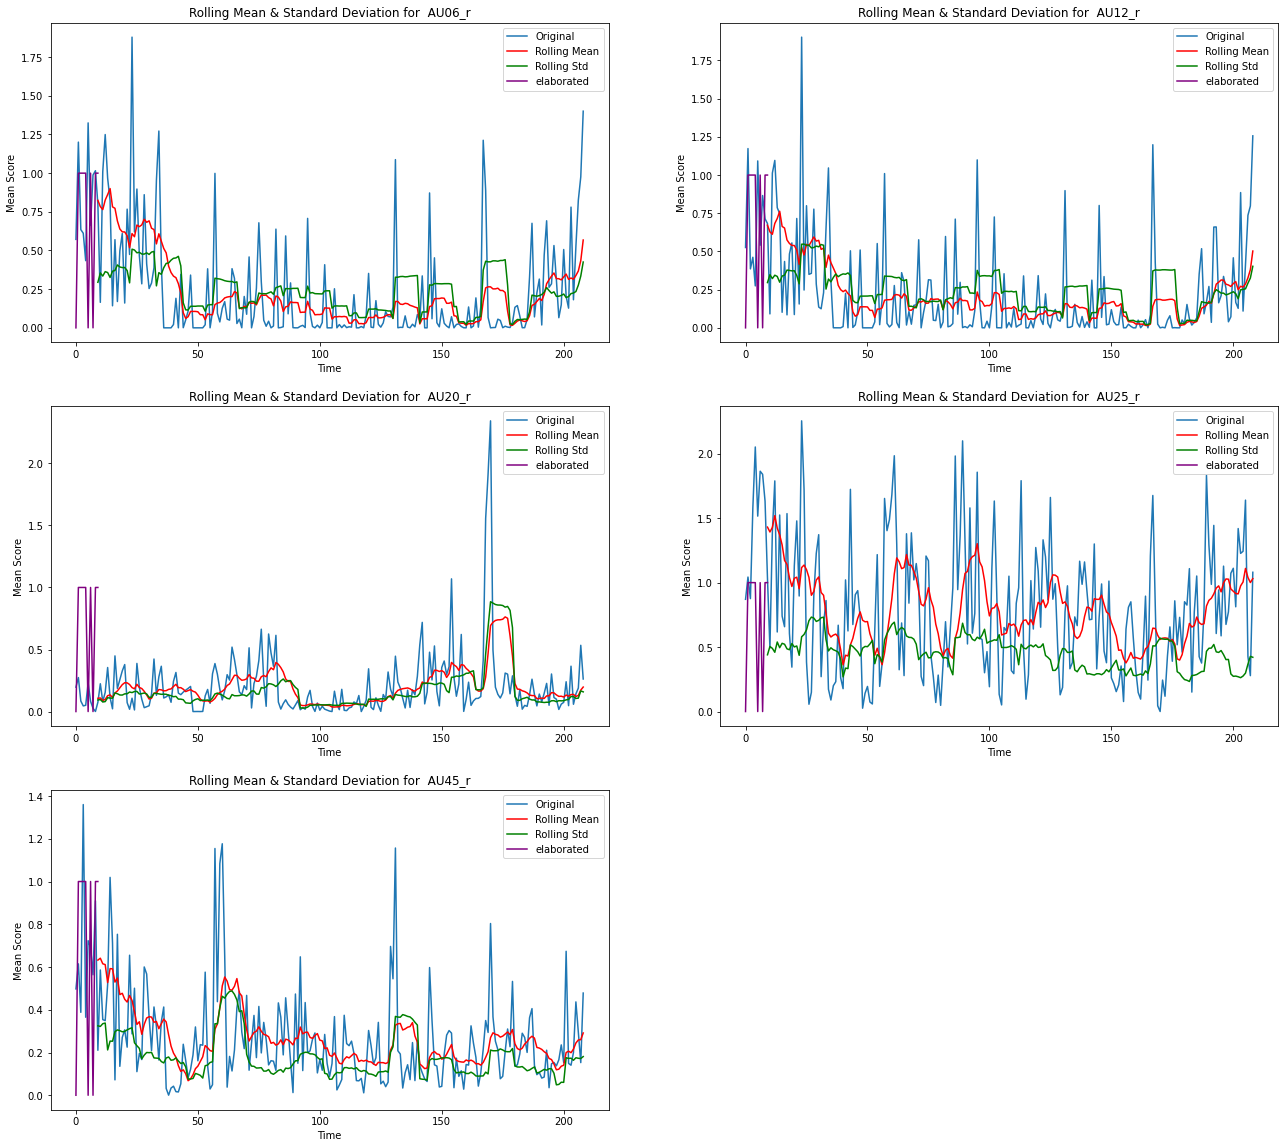

In [39]:
plt.figure(figsize=(22,20)) 
ran, pos = 400, 321
for ele in feature:
    pic(ele, ran, pos)
    pos +=1
plt.show()

 AU06_r: 
Test statistic:  -1.885928438985525
p-value:  0.3387094960047623
Critical Values: {'1%': -3.4638151713286316, '5%': -2.876250632135043, '10%': -2.574611347821651}
 AU12_r: 
Test statistic:  -1.9860421269609434
p-value:  0.2927264742872069
Critical Values: {'1%': -3.4638151713286316, '5%': -2.876250632135043, '10%': -2.574611347821651}
 AU20_r: 
Test statistic:  -7.301366155483278
p-value:  1.3359470270576613e-10
Critical Values: {'1%': -3.4621857592784546, '5%': -2.875537986778846, '10%': -2.574231080806213}
 AU25_r: 
Test statistic:  -9.172244901615151
p-value:  2.3711289561264324e-15
Critical Values: {'1%': -3.4621857592784546, '5%': -2.875537986778846, '10%': -2.574231080806213}
 AU45_r: 
Test statistic:  -3.984897658966422
p-value:  0.0014916891752075896
Critical Values: {'1%': -3.4631437906252636, '5%': -2.8759570379821047, '10%': -2.574454682874228}


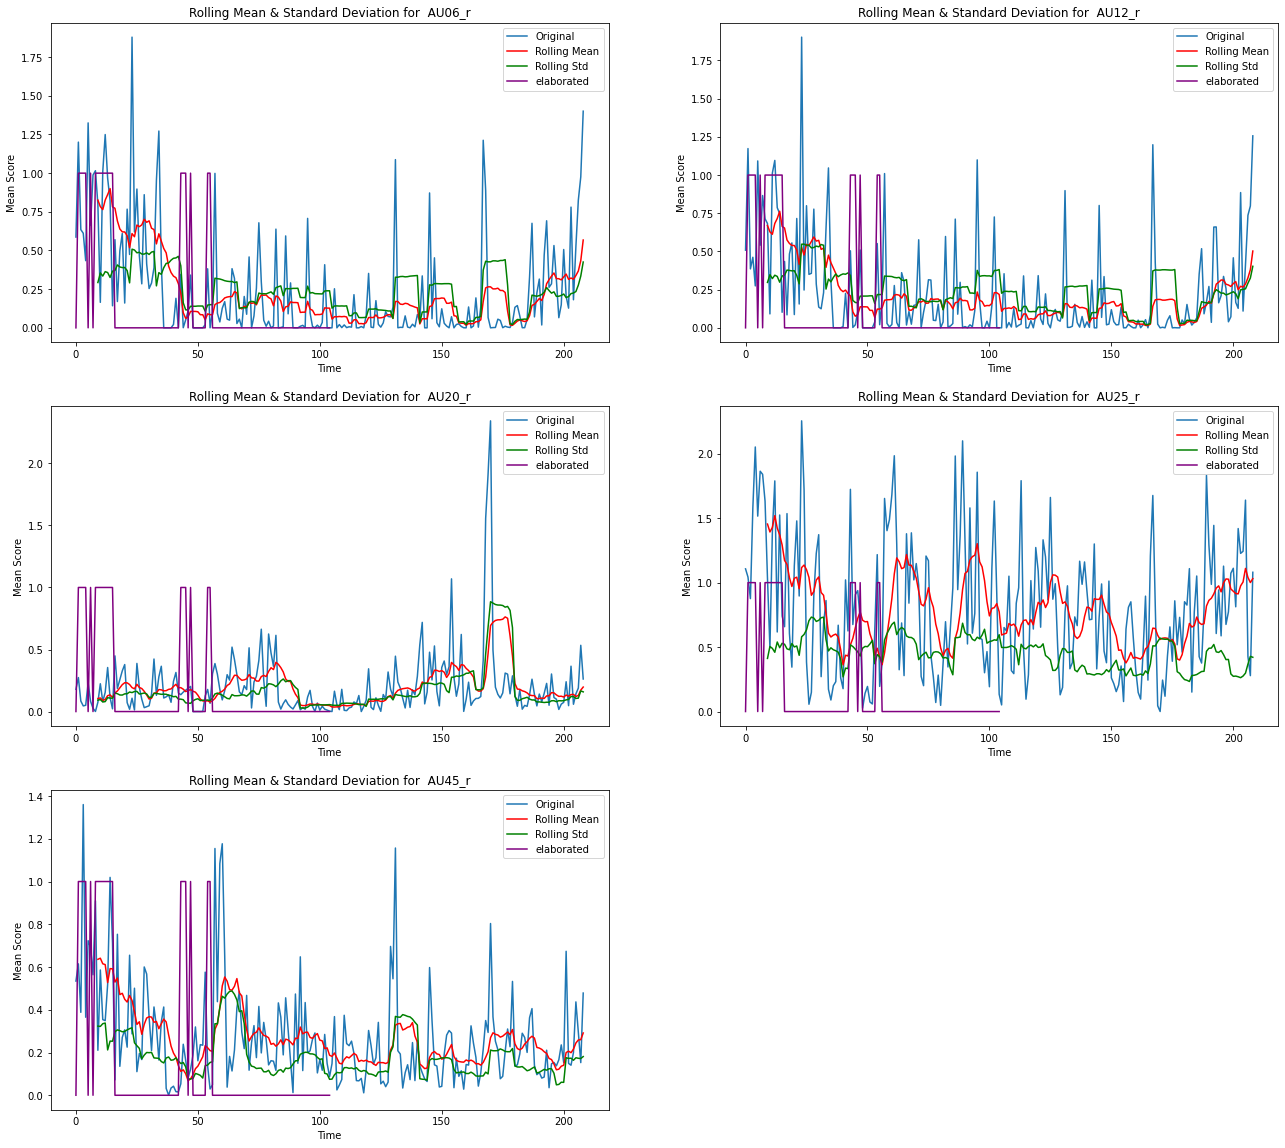

In [41]:
plt.figure(figsize=(22,20)) 
ran, pos = 400, 321
for ele in feature:
    pic(ele, ran, pos)
    pos +=1
plt.show()

In [ ]:
from pandas.plotting import scatter_matrix

#scatterdf = pd.DataFrame(np.random.randn(1000, 4), columns=["a", "b", "c", "d"])

scatter_matrix(au, alpha=0.2, figsize=(6, 6), diagonal="kde");

From this model, we can get:    
• The characteristics of the data is not stationary. From the rolling mean and std, we can see they all changed a lot. For AU06, AU12 and AU45 they all changed greatly at the point around 150, which reflects to the frame around 60000. And for AU20, it is 100. For AU25, it almost changes all the time.   
• There is no seasonality in the figure. All the features and their statistics have no periodic fluctuations.   
• AU06 and AU12 is highly autocorrelated. Actually this conclusion can be obtained easily by the correlation coefficient map of AU. While in this figure, we can also get this correlation intuitively. Both of the two rolling mean and std have a similar distribution with similar raise and flow at the same time.


### Random Forest
Another model I used is Random Forest. The principle of random forest is to vote for every feature and node, which from my perspec- tive is very suitable for our dataset. The features from our dataset all have their own physical meaning and an emotion can be expressed by several features. This decision process can be described easily by a tree structure. That’s the reason why I take it as the second one.
In this process, I conducted this model twice actually. One with the data including important features, and another with data processed by t-SNE.

In [ ]:
sf = au[feature]

In [ ]:
km = KMeans(n_clusters = 6)
y = km.fit_predict(sf)

Here I use t-SNE to visualize the clustered data, while at the same time, I also classify the data using the features whose dimension is reducted by t-SNE.


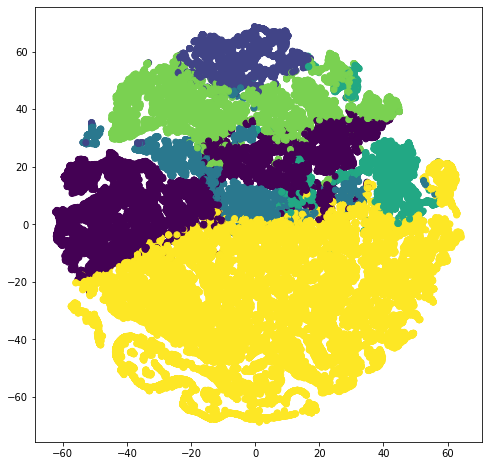

In [ ]:
X_tsne = TSNE(n_components=2).fit_transform(sf)
plt.figure(figsize=(8, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y[:66000],label="t-SNE")
plt.show()

Here I use Random Forest to classify the selected features.

In [ ]:
model = RandomForestClassifier(n_estimators=20)
model.fit(sf[:66000], y[:66000])
pre = model.predict(sf[66000:])
print(classification_report(y[66000:], pre))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9910
           1       0.97      0.98      0.98      2114
           2       0.98      0.99      0.98      2856
           3       0.99      0.96      0.97      1268
           4       0.98      0.96      0.97      1031
           5       0.97      0.95      0.96       378

    accuracy                           0.99     17557
   macro avg       0.98      0.97      0.98     17557
weighted avg       0.99      0.99      0.99     17557



Here I conduct Random Forest on t-SNE features.

In [ ]:
model = RandomForestClassifier(n_estimators=20)
model.fit(X_tsne[:50000], y[:50000])
pre = model.predict(X_tsne[50000:])
print(classification_report(y[50000:66000], pre))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4825
           1       0.96      0.95      0.96      3345
           2       0.92      0.95      0.94      2233
           3       0.92      0.91      0.91      1182
           4       0.97      0.92      0.95      2588
           5       0.96      0.98      0.97      1827

    accuracy                           0.96     16000
   macro avg       0.95      0.95      0.95     16000
weighted avg       0.96      0.96      0.96     16000



In [50]:
# exporting the data
from google.colab import files
df.to_csv('MarMerged.csv', sep=',')
files.download('MarMerged.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>